## Загрузка и рисование файлов

In [87]:
# импорт бибилиотек
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy import stats
#библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns
#библиотеки для модели
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [88]:
#считывание данных
#NH3
nh3_2rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm.xlsx', sheet_name='Untitled')
nh3_25rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH25%.xlsx', sheet_name='Untitled')
nh3_50rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH50%.xlsx', sheet_name='Untitled')
nh3_75rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH75%.xlsx', sheet_name='Untitled')
nh3_2rh_25t_another_ppm = pd.read_excel('Данные для МО/NH3_10_25_50 ppm_RH2%_Room temperature.xlsx', sheet_name='Untitled')

# NO2
no2_2rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_ RH_2%.xlsx', sheet_name='Untitled')
no2_25rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_25%.xlsx', sheet_name='Untitled')
no2_50rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_50%.xlsx', sheet_name='Untitled')
no2_75rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_75%.xlsx', sheet_name='Untitled')
no2_2rh_50t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_50.xlsx', sheet_name='Untitled')
no2_2rh_70t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_70_RH2%.xlsx', sheet_name='Untitled')
no2_2rh_90t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_90.xlsx', sheet_name='Untitled')

In [89]:
nh3_2rh_25t

,R [Ом],Time [с]
0,0.000000,0.0
1,1916.370361,0.5
2,1917.799194,1.0
3,1914.129395,1.5
4,1916.431519,2.0
...,...,...
12595,1980.580811,6300.0
12596,1982.384766,6300.5
12597,1980.985718,6301.0
12598,1981.931763,6301.5


In [90]:
#строим график зависимости сопротивления от времени
def dependency_graphs(gas, title):
    gas = gas.iloc[1:]# для того чтобы убрать (0,0)
    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas)# что и откуда берем

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    title_string = f'Точечный график зависимости сопротивления от времени газа {title}'
    plt.title(title_string)
    plt.grid(True)#добавим сеточку

    return plt.show()

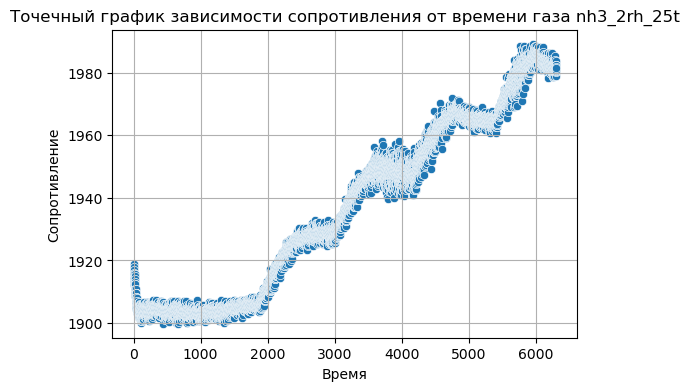

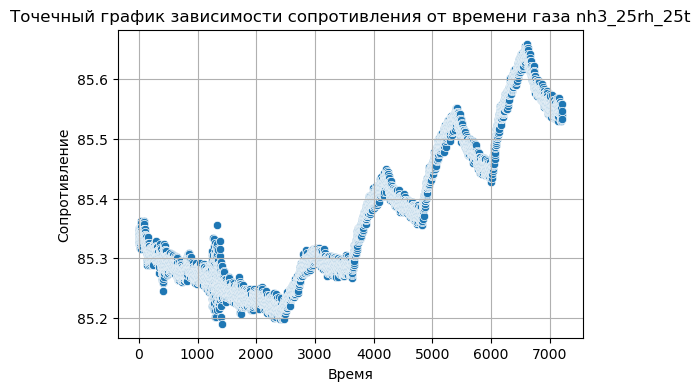

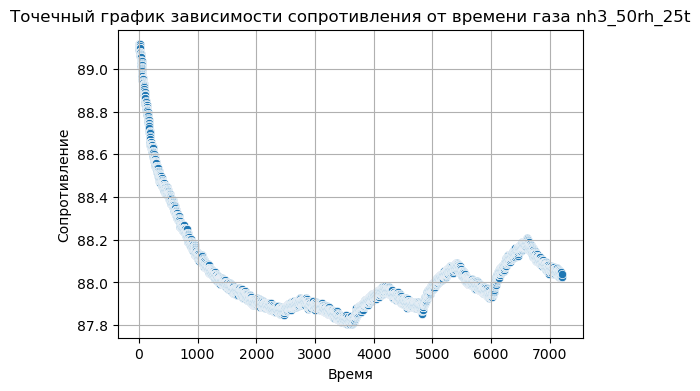

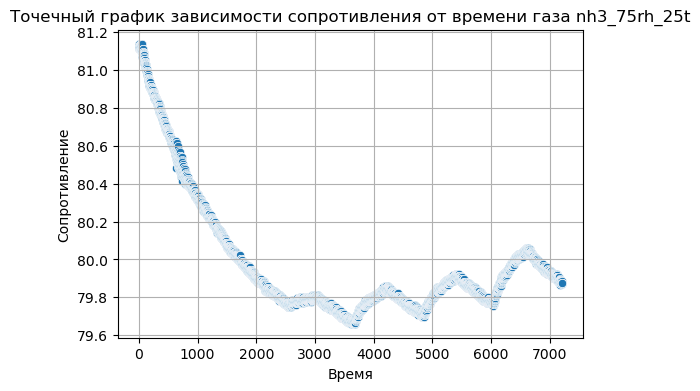

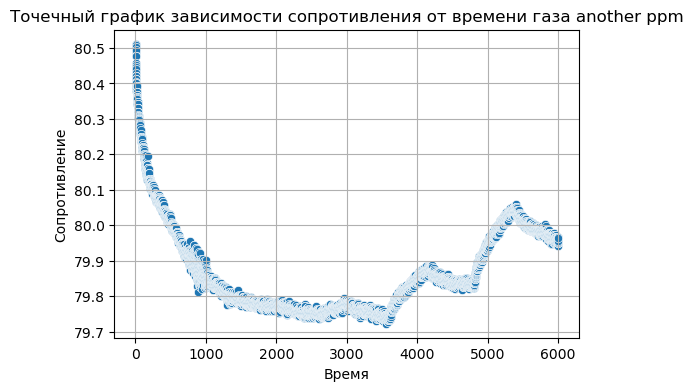

In [91]:
#графики NH3 при одинаковой температуре и разной влажности
nh3_2rh_25t_graph= dependency_graphs(nh3_2rh_25t, title = 'nh3_2rh_25t')
nh3_25rh_25t_graph = dependency_graphs(nh3_25rh_25t, title = 'nh3_25rh_25t')
nh3_50rh_25t_graph = dependency_graphs(nh3_50rh_25t, title = 'nh3_50rh_25t')
nh3_75rh_25t_graph = dependency_graphs(nh3_75rh_25t, title = 'nh3_75rh_25t')

nh3_2rh_25t_another_ppm_graph = dependency_graphs(nh3_2rh_25t_another_ppm, title='another ppm')

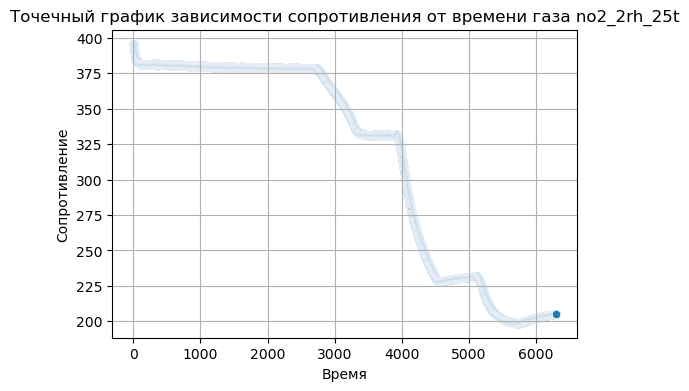

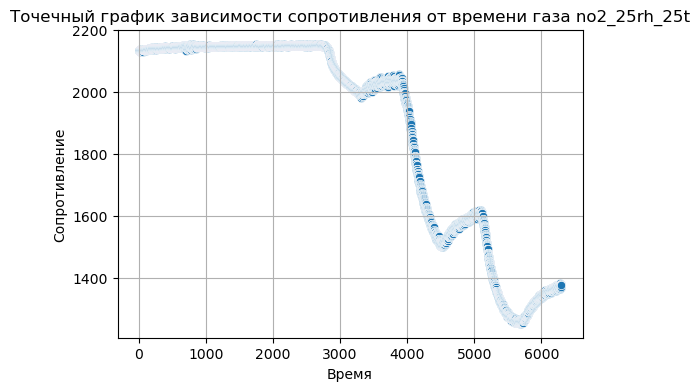

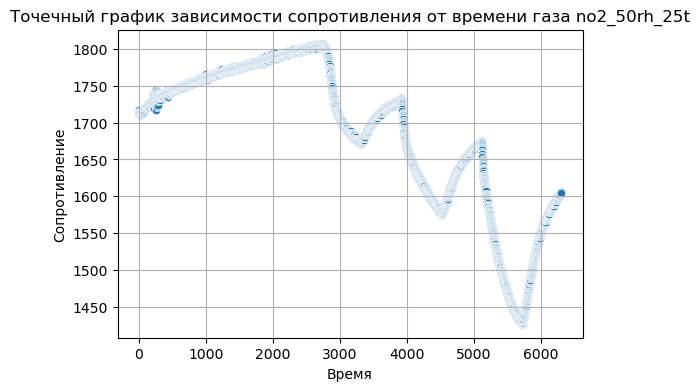

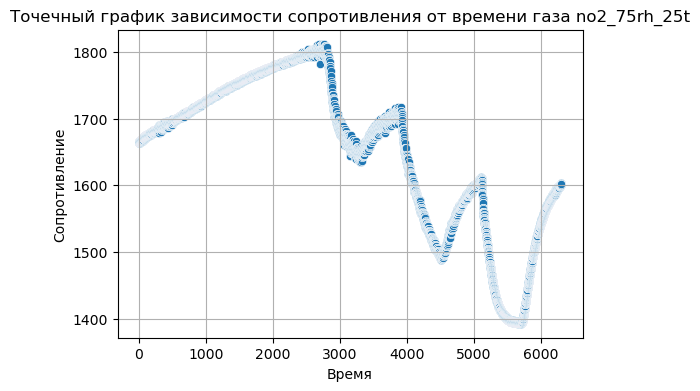

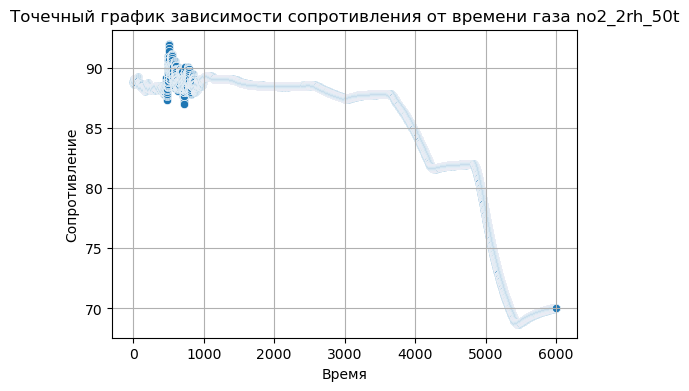

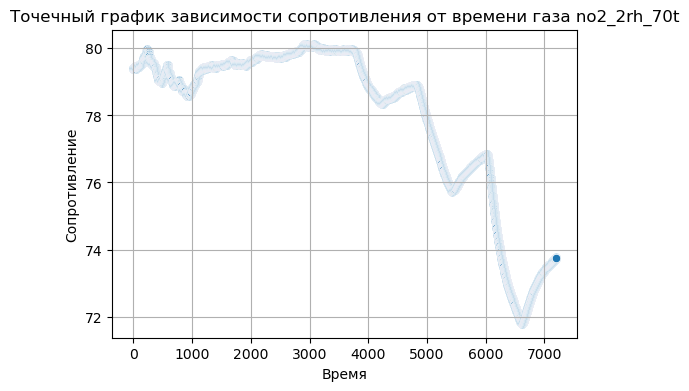

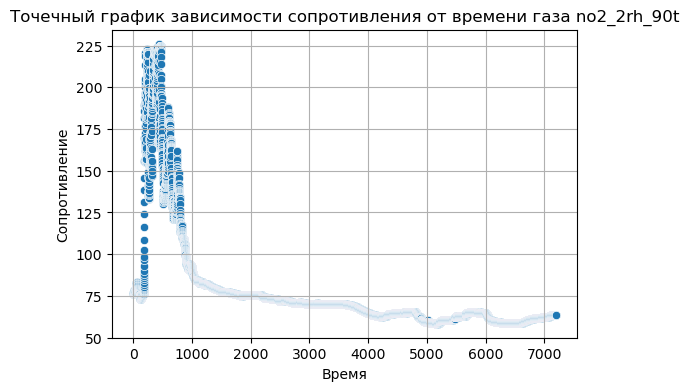

In [92]:
#графики NO2 при одинаковой температуре и разной влажности
no2_2rh_25t_graph = dependency_graphs(no2_2rh_25t, title = 'no2_2rh_25t')
no2_25rh_25t_graph = dependency_graphs(no2_25rh_25t, title = 'no2_25rh_25t')
no2_50rh_25t_graph = dependency_graphs(no2_50rh_25t, title = 'no2_50rh_25t')
no2_75rh_25t_graph = dependency_graphs(no2_75rh_25t, title='no2_75rh_25t')

#графики NO2 при температуре 50t
no2_2rh_50t_graph = dependency_graphs(no2_2rh_50t, title = 'no2_2rh_50t')

#графики NO2 при температуре 70t
no2_2rh_70t_graph = dependency_graphs(no2_2rh_70t,title='no2_2rh_70t')

#графики NO2 при температуре 90t
no2_2rh_90t_graph = dependency_graphs(no2_2rh_90t, title = 'no2_2rh_90t')

In [93]:
nh3_2rh_25t = nh3_2rh_25t.iloc[1:]
nh3_2rh_25t = nh3_2rh_25t.reset_index(drop=True)

nh3_25rh_25t = nh3_25rh_25t.iloc[1:]
nh3_25rh_25t = nh3_25rh_25t.reset_index(drop=True)

nh3_50rh_25t = nh3_50rh_25t.iloc[1:]
nh3_50rh_25t = nh3_50rh_25t.reset_index(drop=True)

nh3_75rh_25t = nh3_75rh_25t.iloc[1:]
nh3_75rh_25t = nh3_75rh_25t.reset_index(drop=True)

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[1:]
nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.reset_index(drop=True)


no2_2rh_25t = no2_2rh_25t.iloc[1:]
no2_2rh_25t = no2_2rh_25t.reset_index(drop=True)

no2_25rh_25t = no2_25rh_25t.iloc[1:]
no2_25rh_25t = no2_25rh_25t.reset_index(drop=True)

no2_50rh_25t = no2_50rh_25t.iloc[1:]
no2_50rh_25t = no2_50rh_25t.reset_index(drop=True)

no2_75rh_25t = no2_75rh_25t.iloc[1:]
no2_75rh_25t = no2_75rh_25t.reset_index(drop=True)


no2_2rh_50t = no2_2rh_50t.iloc[1:]
no2_2rh_50t = no2_2rh_50t.reset_index(drop=True)

no2_2rh_70t = no2_2rh_70t.iloc[1:]
no2_2rh_70t = no2_2rh_70t.reset_index(drop=True)

no2_2rh_90t = no2_2rh_90t.iloc[1:]
no2_2rh_90t = no2_2rh_90t.reset_index(drop=True)
#nh3_2rh_25t

In [94]:
nh3_2rh_25t

,R [Ом],Time [с]
0,1916.370361,0.5
1,1917.799194,1.0
2,1914.129395,1.5
3,1916.431519,2.0
4,1915.614380,2.5
...,...,...
12594,1980.580811,6300.0
12595,1982.384766,6300.5
12596,1980.985718,6301.0
12597,1981.931763,6301.5


## Выявление тренда

Попробуем так: сначала усредним все точки, а потом найдем точки изменения тренда

Итак, мы усреднили наши данные, теперь попробуем использовать критерий Чоя, для того, чтобы он точно подтвердил, что предположительная точка смены тренда именно та, которая есть

In [95]:
def average_line_from_dataframe(df, resistance_col='R [Ом]', time_col='Time [с]', window_size=505, polynomial_order=3):
    """
    Проводим среднюю линию через множество точек зависимости сопротивления от времени,
    используя фильтр Савицкого-Голея
    Args:
        Датафрейм с данными: сопротивление и время!
        resistance_col (str): Название столбца с данными сопротивления
        time_col (str): Название столбца с данными времени
        window_size (int): Длина окна фильтра, должна быть нечетным числом.
                           Чем больше значение, тем более сглаженной будет кривая.
                           Рекомендуемые значения: 21, 51, 101(но нам сейчас не особо идут такие значения)
        polynomial_order (int): Порядок полинома, используемого для фильтрации
                                 Обычно используют 2 или 3
    Returns:
        array-like: Массив значений сглаженного сопротивления (средняя линия).
    """

    ################Проверка входных данных################
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Входные данные должны быть DataFrame.")

    if resistance_col not in df.columns or time_col not in df.columns:
        raise ValueError(f"DataFrame должен содержать столбцы '{resistance_col}' и '{time_col}'.")
    ############################################################################################
    
    #переводим в массиы нумпаевский
    time = df[time_col].to_numpy()
    resistance = df[resistance_col].to_numpy()

############Проверки массивов№№№№№№№№№№№№№№№№№№№№№№№№
    if len(time) != len(resistance):
        raise ValueError("Столбцы времени и сопротивления должны иметь одинаковую длину.")

    if window_size % 2 == 0:
        raise ValueError("Размер окна должен быть нечетным.")

    if window_size > len(resistance):
        raise ValueError("Размер окна не может быть больше длины данных.")

    #Фильтр Савицкого-Голея
    resistance_smooth = savgol_filter(resistance, window_size, polynomial_order)

    return resistance_smooth

# Параметры фильтра  
polynomial_order = 3


In [96]:
#применение
#NH3 temp = 25
res_average_nh3_2rh_25t= average_line_from_dataframe(nh3_2rh_25t,window_size=1101, polynomial_order=polynomial_order)# +++
res_average_nh3_25rh_25t = average_line_from_dataframe(nh3_25rh_25t,window_size=2009,polynomial_order=polynomial_order)# +++
res_average_nh3_50rh_25t = average_line_from_dataframe(nh3_50rh_25t,window_size=1501,polynomial_order=polynomial_order)# +++
res_average_nh3_75rh_25t = average_line_from_dataframe(nh3_75rh_25t, window_size=1707, polynomial_order=polynomial_order)# +++

# к сожалению, он не очень, его приблизить хорошо не удалось
res_average_nh3_2rh_25t_another_ppm = average_line_from_dataframe(nh3_2rh_25t_another_ppm, window_size=2209, polynomial_order=polynomial_order)

#NO2 temp = 25
#он тоже не очень приблизился
res_average_no2_2rh_25t = average_line_from_dataframe(no2_2rh_25t, window_size=101, polynomial_order=polynomial_order)#+--
#он тоже не очень приблизился
res_average_no2_25rh_25t = average_line_from_dataframe(no2_25rh_25t, window_size=1001, polynomial_order=polynomial_order)#+--
res_average_no2_50rh_25t = average_line_from_dataframe(no2_50rh_25t, window_size=1303, polynomial_order=polynomial_order)# +++
res_average_no2_75rh_25t = average_line_from_dataframe(no2_75rh_25t, window_size=1001, polynomial_order=polynomial_order)# +++

#NO2 temp = 50
res_average_no2_2rh_50t = average_line_from_dataframe(no2_2rh_50t, window_size=1909,polynomial_order=polynomial_order)# ++-

#NO2 temp = 70
#Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
res_average_no2_2rh_70t = average_line_from_dataframe(no2_2rh_70t, window_size=4001, polynomial_order=polynomial_order)# ---

#NO2 temp = 90
res_average_no2_2rh_90t = average_line_from_dataframe(no2_2rh_90t, window_size=1301, polynomial_order=polynomial_order)# +++


In [97]:
len(res_average_no2_2rh_25t)

12599

## ПРОБУЕМ НОВЫЙ ПОДХОД

Что если наш усредненный массив мы будем делить на несколько частей, можем даже рассматривать не весь набор данных, а, например, первые 6000 строк(3000с). Этот набор данных разделим на несколько частей, допустим, на 6, в каждой части будем искать минимум(максимум), и затем будем сравнивать между собой разность значений минимумов(максимумов) среди последовательных промежутков. Чем больше окажется разность по модулю, значит, вероятно, смена тренда находится именно там, в минимуме(максимуме) прмоежутка слева.


Либо можно попробовать сделать так - разница между средними значениями наибольшая по модулю. И соответственно потом ищется минимум(максимум) в соответствующем предыдущем отрезке, вероятно, он и будет считаться точкой смены тренда

In [98]:
# def find_min(smoothed_data):
#     """
#     Находит минимум в массиве сглаженных данных, деля его на 6 частей.
#     Если максимальная разность между последовательными минимумами превышает пороговое значение, 
#     возвращает индекс минимума в более раннем промежутке.

#     Args:
#         smoothed_data: Массив сглаженных данных (NumPy array).

#     Returns:
#         Индекс минимума в массиве smoothed_data. Возвращает -1, если входные данные некорректны.
#     """
#     if not isinstance(smoothed_data, np.ndarray) or len(smoothed_data) < 6000:
#         return -1

#     data = smoothed_data[:6000]  # Берем первые 6000 элементов
#     chunk_size = len(data) // 6
#     minima = []

#     for i in range(6):
#         start = i * chunk_size
#         end = (i + 1) * chunk_size
#         if i == 5:
#             end = len(data)
#         chunk = data[start:end]
#         minima.append(np.min(chunk))

#     max_diff = 0
#     max_diff_index = -1

#     for i in range(1, len(minima)):
#         diff = abs(minima[i] - minima[i - 1])
#         if diff > max_diff:
#             max_diff = diff
#             max_diff_index = i - 1

#     threshold = 0.00000000001  # Пример порогового значения. Настройте под ваши данные.

#     if max_diff > threshold and max_diff_index != -1:
#         start = max_diff_index * chunk_size
#         end = (max_diff_index + 1) * chunk_size
#         chunk = data[start:end]
#         min_index_in_chunk = np.argmin(chunk)  # Используем argmin для нахождения индекса
#         return start + min_index_in_chunk
#     else:
#         min_index = np.argmin(data)  # Используем argmin для нахождения индекса
#         return min_index

    
    
# trend_chande_point_nh3_2rh_25t = find_min(res_average_nh3_2rh_25t)


In [99]:
def find_global_extremum(data, find_min):
    """
    Находит глобальный минимум или максимум в массиве данных.

    Args:
        data: Массив данных (NumPy array).
        find_min: True для поиска минимума, False для максимума.

    Returns:
        Индекс глобального минимума/максимума в массиве data. 
        Возвращает -1, если входные данные некорректны.
    """
    if not isinstance(data, np.ndarray) or len(data) == 0:
        return -1

    if find_min:
        return np.argmin(data)
    else:
        return np.argmax(data)

In [100]:
#NH3
trend_chande_point_nh3_2rh_25t = find_global_extremum(res_average_nh3_2rh_25t,find_min=True)
trend_chande_point_nh3_25rh_25t = find_global_extremum(res_average_nh3_25rh_25t, find_min=True)
trend_chande_point_nh3_50rh_25t = find_global_extremum(res_average_nh3_50rh_25t, find_min=True)
trend_chande_point_nh3_75rh_25t = find_global_extremum(res_average_nh3_75rh_25t, find_min=True)

trend_chande_point_nh3_2rh_25t_another_ppm = find_global_extremum(res_average_nh3_2rh_25t_another_ppm, find_min=True)

#NO2 temp = 25t
trend_chande_point_no2_2rh_25t = find_global_extremum(res_average_no2_2rh_25t,find_min=False)
trend_chande_point_no2_25rh_25t = find_global_extremum(res_average_no2_25rh_25t,find_min=False)
trend_chande_point_no2_50rh_25t = find_global_extremum(res_average_no2_50rh_25t,find_min=False)
trend_chande_point_no2_75rh_25t = find_global_extremum(res_average_no2_75rh_25t,find_min=False)

#NO2 temp = 50
trend_chande_point_no2_2rh_50t = find_global_extremum(res_average_no2_2rh_50t,find_min=False)

#NO2 temp = 70
trend_chande_point_no2_2rh_70t = find_global_extremum(res_average_no2_2rh_70t,find_min=False)

#NO2 temp = 90
trend_chande_point_no2_2rh_90t = find_global_extremum(res_average_no2_2rh_90t,find_min=False)

In [101]:
trend_chande_point_no2_2rh_25t

0

In [102]:
trend_chande_point_nh3_2rh_25t

415

In [103]:
# def find_min(smoothed_data):
#     """
#     Находит минимум в массиве сглаженных данных, деля его на 6 частей.
#     Если максимальная разность между последовательными минимумами превышает пороговое значение, 
#     возвращает индекс минимума в более раннем промежутке.

#     Args:
#         smoothed_data: Массив сглаженных данных (числа).

#     Returns:
#         Индекс минимума в массиве smoothed_data. Возвращает -1, если входные данные некорректны.
#     """
#     if not isinstance(smoothed_data, list) or len(smoothed_data) < 6000:
#         return -1  # Обработка некорректных входных данных

#     data = smoothed_data[:6000]  # Берем первые 6000 элементов
#     chunk_size = len(data) // 6
#     minima = []

#     for i in range(6):
#         start = i * chunk_size
#         end = (i + 1) * chunk_size  #Обработка последнего чанка
#         if i == 5:
#             end = len(data)
#         chunk = data[start:end]
#         minima.append(min(chunk))

#     max_diff = 0
#     max_diff_index = -1

#     for i in range(1, len(minima)):
#         diff = abs(minima[i] - minima[i - 1])
#         if diff > max_diff:
#             max_diff = diff
#             max_diff_index = i -1 #Индекс более раннего промежутка


#     #Если максимальная разница превышает порог (можно настроить)
#     threshold = 10 #Пример порогового значения. Настройте под ваши данные.

#     if max_diff > threshold and max_diff_index != -1:
#       #Находим индекс минимума в более раннем промежутке
#       start = max_diff_index * chunk_size
#       end = (max_diff_index + 1) * chunk_size
#       chunk = data[start:end]
#       min_value = min(chunk)
#       min_index_in_chunk = chunk.index(min_value)
#       return start + min_index_in_chunk
#     else:
#         # Если разница не превышает порог, возвращаем индекс глобального минимума
#         min_value = min(data)
#         return data.index(min_value)


# # #Пример использования:
# # smoothed_data = list(range(10000)) #Пример данных
# # min_index = find_min(smoothed_data)
# # print(f"Индекс минимума: {min_index}")


# smoothed_data = [10, 20, 100, 5, 15, 25, 105, 10, 20, 1000, 5000, 10000] * 500
# min_index = find_min(smoothed_data)
# print(f"Индекс минимума: {min_index}")



In [104]:
# def find_trend_change_point(smoothed_data, threshold=0):
#     """
#     Находит точку смены тренда в сглаженных данных, определяется по смене знака первой производной.
#     Args:
#         smoothed_data (array-like): Сглаженные данные
#         threshold (float): Порог для определения смены тренда, учитывает небольшой шум.
#     Returns:
#         int: Индекс точки смены тренда. Возвращает None, если смена тренда не найдена.
#     """
#     # Вычисляем первую производную (с помощью разности)
#     derivatives = np.diff(smoothed_data)

#     # Находим индексы, где производная меняет знак
#     trend_change_indices = np.where(np.diff(np.sign(derivatives)))[0] + 1  # +1 т.к. diff уменьшает размер массива на 1

#     # Если индексы не найдены, возвращаем None
#     if len(trend_change_indices) == 0:
#         return None

#     # Учитываем порог: проверяем, что изменение производной значительно (больше порога)
#     for index in trend_change_indices:
#       if abs(derivatives[index] - derivatives[index-1]) > threshold:
#         return index

#     return None  

In [105]:
# #NH3 temp = 25
# trend_change_index_nh3_2rh_25t = find_trend_change_point(res_average_nh3_2rh_25t, threshold=0.005)# +++
# trend_change_index_nh3_25rh_25t = find_trend_change_point(res_average_nh3_25rh_25t, threshold=0.00001)# +++
# trend_change_index_nh3_50rh_25t = find_trend_change_point(res_average_nh3_50rh_25t,threshold=0.00001)# +++
# trend_change_index_nh3_75rh_25t = find_trend_change_point(res_average_nh3_75rh_25t,threshold=0.00001)# +++

# # к сожалению, он не очень, его приблизить хорошо не удалось
# trend_change_index_nh3_2rh_25t_another_ppm = find_trend_change_point(res_average_nh3_2rh_25t_another_ppm,threshold=0.000000001)

# #NO2 temp = 25
# #он тоже не очень приблизился
# trend_change_index_no2_2rh_25t = find_trend_change_point(res_average_no2_2rh_25t,threshold=0.00005)# +--
# #он тоже не очень приблизился
# trend_change_index_no2_25rh_25t = find_trend_change_point(res_average_no2_25rh_25t,threshold=0.01)#+--
# trend_change_index_no2_50rh_25t = find_trend_change_point(res_average_no2_50rh_25t,threshold=0.001)# +++
# trend_change_index_no2_75rh_25t = find_trend_change_point(res_average_no2_75rh_25t,threshold=0.00001)# +++

# #NO2 temp = 50
# trend_change_index_no2_2rh_50t = find_trend_change_point(res_average_no2_2rh_50t,threshold=0.0001)# ++-

# #NO2 temp = 70
# #Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
# trend_change_index_no2_2rh_70t = find_trend_change_point(res_average_no2_2rh_70t,threshold=0.00001)# ---

# #NO2 temp = 90
# trend_change_index_no2_2rh_90t = find_trend_change_point(res_average_no2_2rh_90t,threshold=0.001)# +++

In [106]:
def average_line_ris(df,resistance_smooth,trend_change_index, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time [с]'], df['R [Ом]'], label='Исходные данные')
    plt.plot(df['Time [с]'], resistance_smooth, label=f'Средняя линия (S-G, win=, order={polynomial_order})', linewidth=2)
    if trend_change_index is not None:
        plt.axvline(x=df['Time [с]'][trend_change_index], color='red', linestyle='--', label=f'Смена тренда (индекс {trend_change_index})')
    plt.xlabel('Время')
    plt.ylabel('Сопротивление')
    title_string = f'Сглаживание зависимости сопротивления от времени {title}'
    plt.title(title_string)
    plt.legend()
    plt.grid(True)
    plt.show()

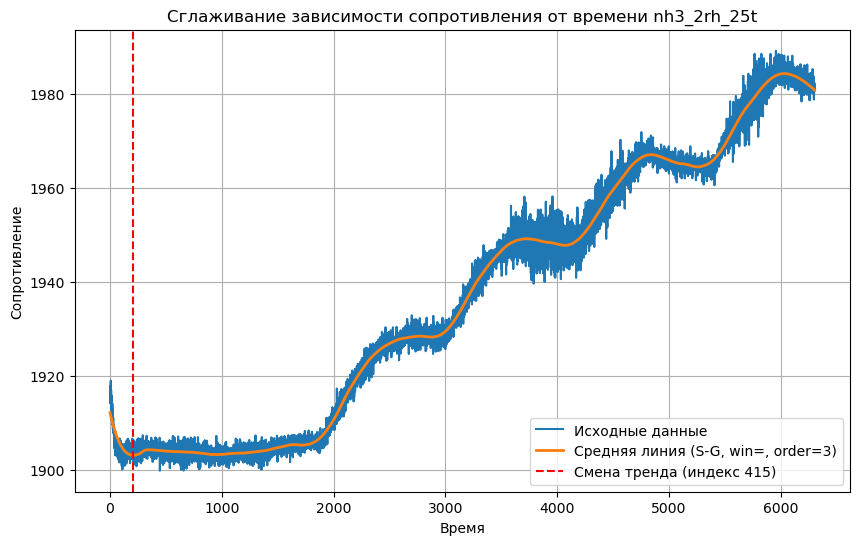

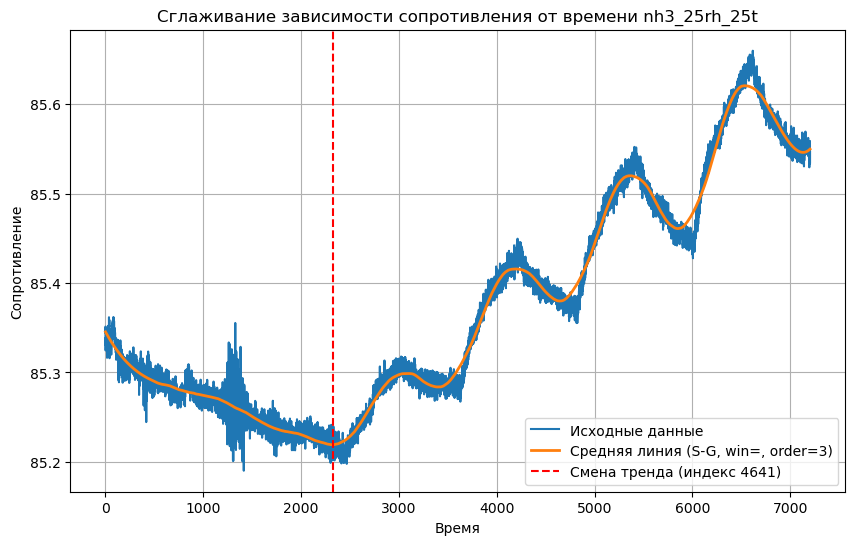

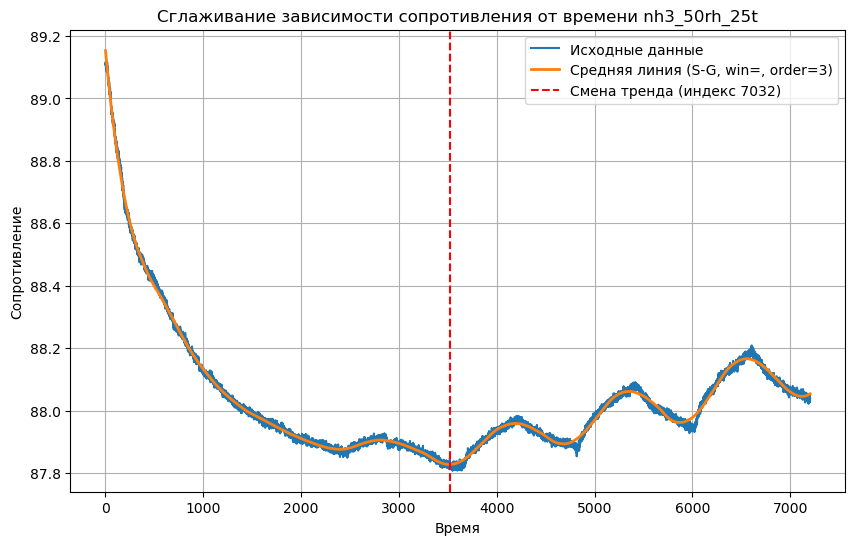

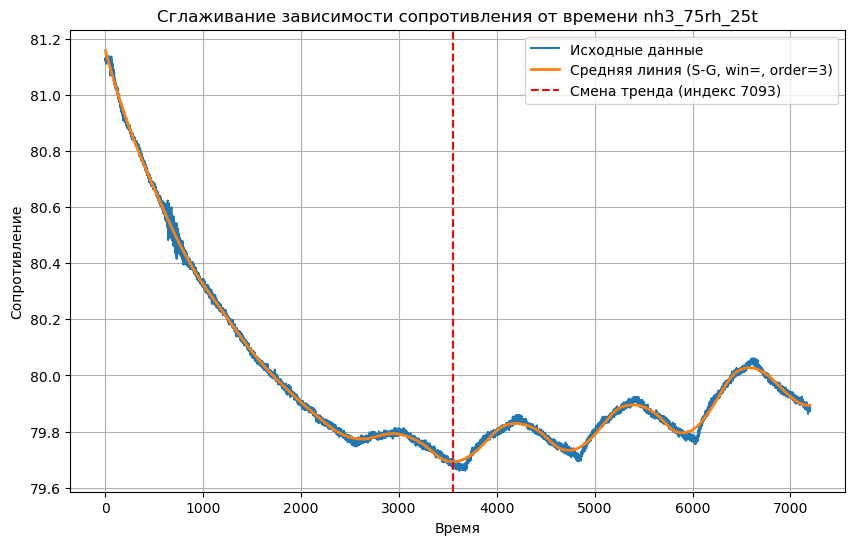

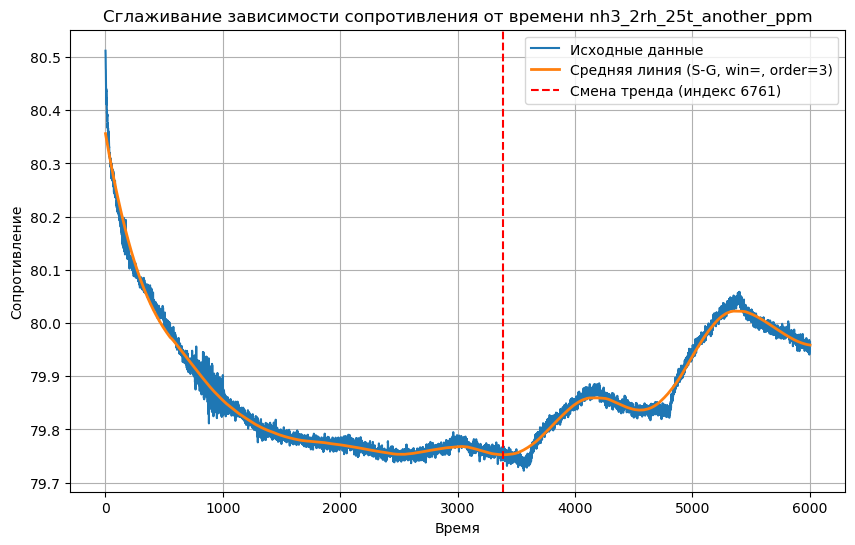

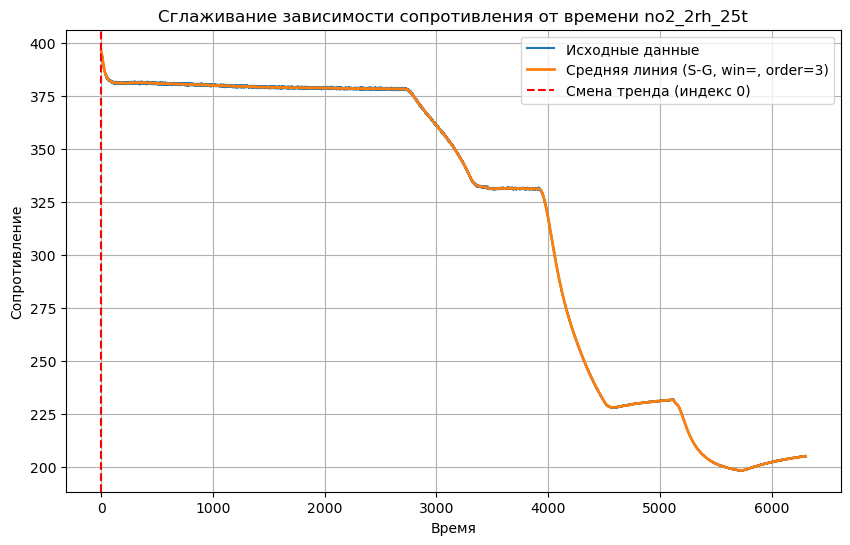

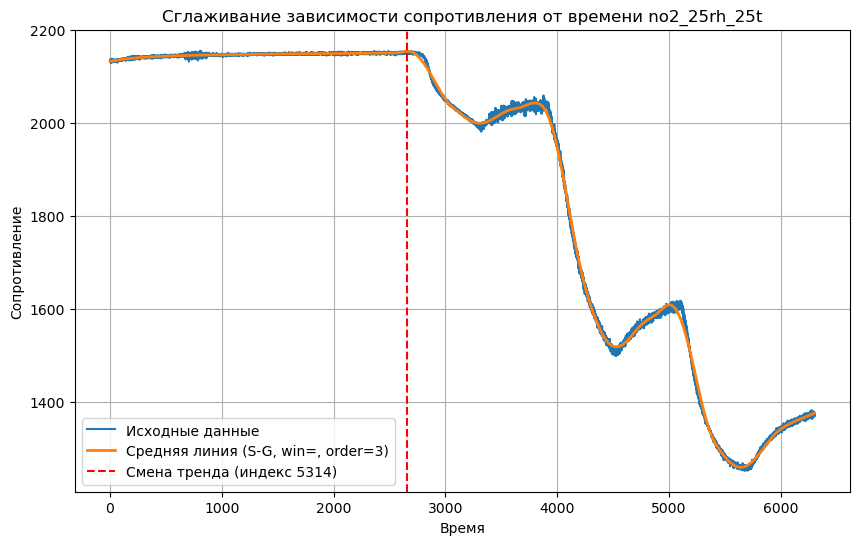

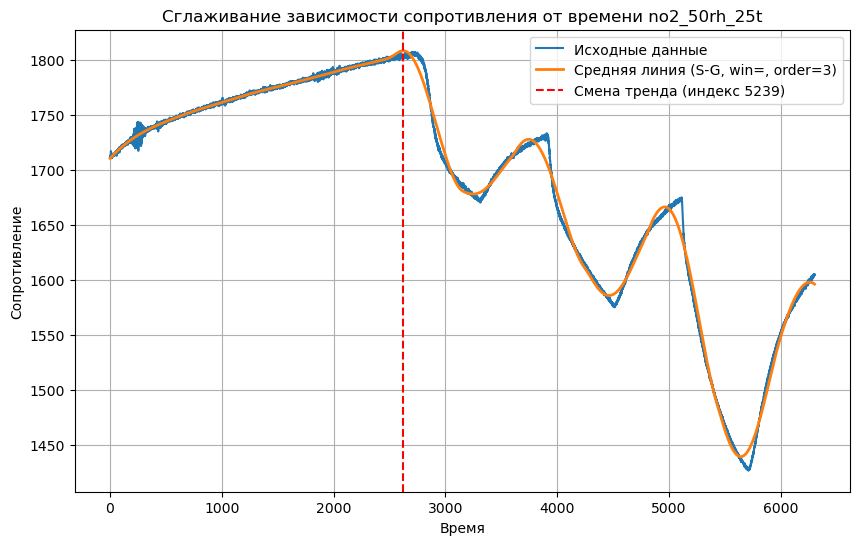

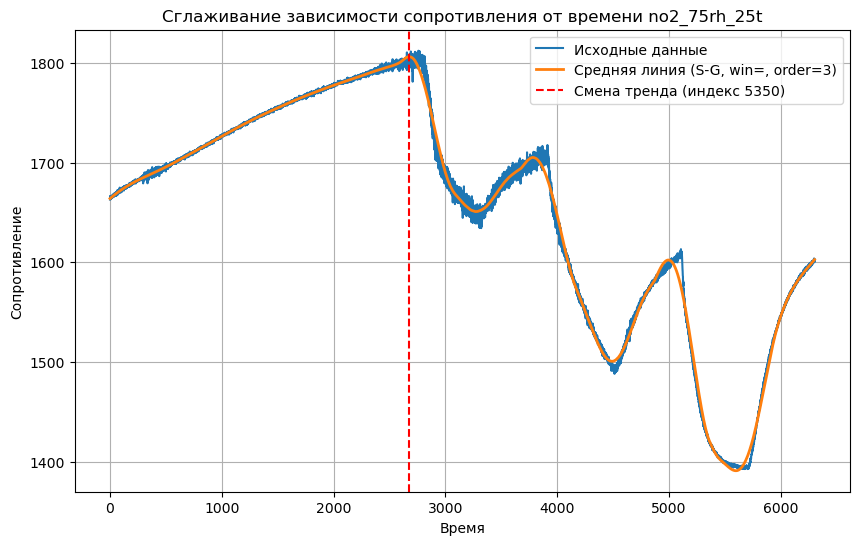

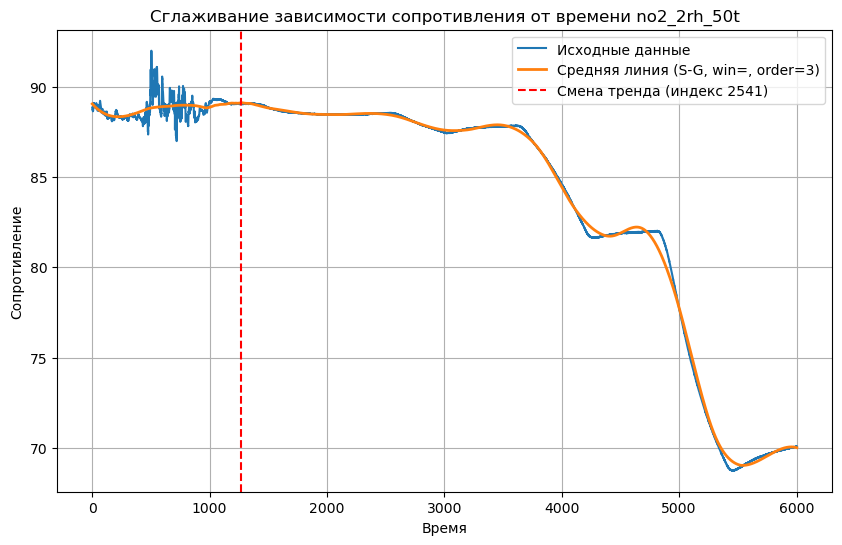

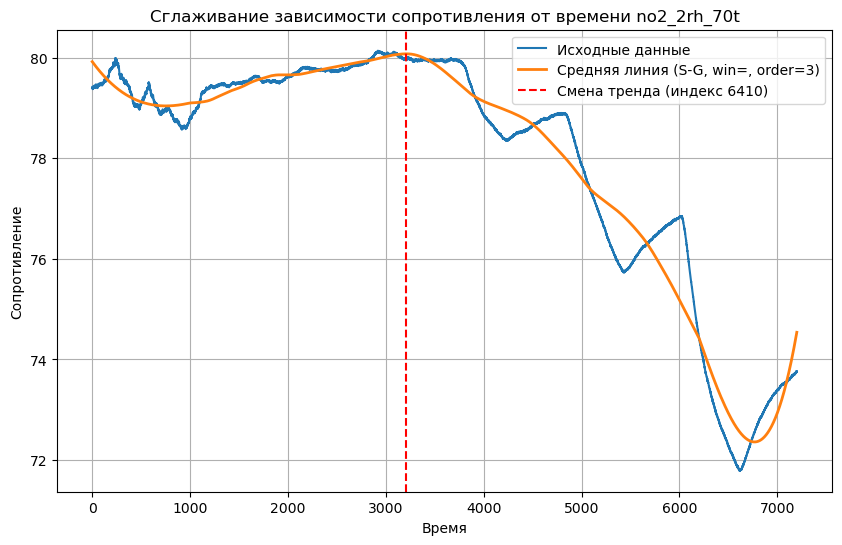

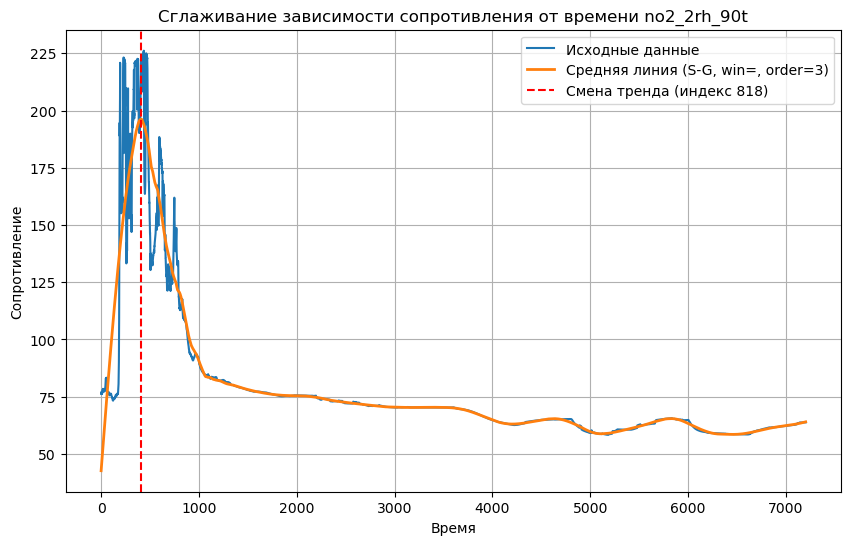

In [107]:
#NH3
nh3_2rh_25t_ris = average_line_ris(nh3_2rh_25t, res_average_nh3_2rh_25t, trend_chande_point_nh3_2rh_25t, 'nh3_2rh_25t')# +++
nh3_25rh_25t_ris = average_line_ris(nh3_25rh_25t, res_average_nh3_25rh_25t, trend_chande_point_nh3_25rh_25t, 'nh3_25rh_25t')# +++
nh3_50rh_25t_ris = average_line_ris(nh3_50rh_25t, res_average_nh3_50rh_25t, trend_chande_point_nh3_50rh_25t, 'nh3_50rh_25t')
nh3_75rh_25t_ris = average_line_ris(nh3_75rh_25t, res_average_nh3_75rh_25t, trend_chande_point_nh3_75rh_25t, 'nh3_75rh_25t')

nh3_2rh_25t_ris_another_ppm = average_line_ris(nh3_2rh_25t_another_ppm, res_average_nh3_2rh_25t_another_ppm, trend_chande_point_nh3_2rh_25t_another_ppm, 'nh3_2rh_25t_another_ppm')

#NO2 temp = 25
no2_2rh_25t_ris = average_line_ris(no2_2rh_25t, res_average_no2_2rh_25t, trend_chande_point_no2_2rh_25t, 'no2_2rh_25t')
no2_25rh_25t_ris = average_line_ris(no2_25rh_25t, res_average_no2_25rh_25t, trend_chande_point_no2_25rh_25t, 'no2_25rh_25t')
no2_50rh_25t_ris = average_line_ris(no2_50rh_25t, res_average_no2_50rh_25t, trend_chande_point_no2_50rh_25t, 'no2_50rh_25t')
no2_75rh_25t_ris = average_line_ris(no2_75rh_25t, res_average_no2_75rh_25t, trend_chande_point_no2_75rh_25t, 'no2_75rh_25t')

#NO2 temp = 50
no2_2rh_50t_ris = average_line_ris(no2_2rh_50t, res_average_no2_2rh_50t, trend_chande_point_no2_2rh_50t, 'no2_2rh_50t')

#NO2 temp = 70
no2_2rh_70t_ris = average_line_ris(no2_2rh_70t, res_average_no2_2rh_70t, trend_chande_point_no2_2rh_70t, 'no2_2rh_70t')

#NO2 temp = 90
no2_2rh_90t_ris = average_line_ris(no2_2rh_90t, res_average_no2_2rh_90t, trend_chande_point_no2_2rh_90t, 'no2_2rh_90t')

In [27]:
# #NH3 temp - 25
# nh3_2rh_25t_ris = average_line_ris(nh3_2rh_25t, res_average_nh3_2rh_25t, trend_change_index_nh3_2rh_25t, 'nh3_2rh_25t')# +++
# nh3_25rh_25t_ris = average_line_ris(nh3_25rh_25t, res_average_nh3_25rh_25t, trend_change_index_nh3_25rh_25t, 'nh3_25rh_25t')# +++
# nh3_50rh_25t_ris = average_line_ris(nh3_50rh_25t, res_average_nh3_50rh_25t, trend_change_index_nh3_50rh_25t, 'nh3_50rh_25t')# +++
# nh3_75rh_25t_ris = average_line_ris(nh3_75rh_25t, res_average_nh3_75rh_25t, trend_change_index_nh3_75rh_25t, 'nh3_75rh_25t')# +++

# # к сожалению, он не очень, его приблизить хорошо не удалось
# nh3_2rh_25t_another_ppm_ris = average_line_ris(nh3_2rh_25t_another_ppm,res_average_nh3_2rh_25t_another_ppm,trend_change_index_nh3_2rh_25t_another_ppm, 'nh3_2rh_25t_another_ppm')

# #NO2 temp - 25
# #он тоже не очень приблизился
# no2_2rh_25t_ris = average_line_ris(no2_2rh_25t, res_average_no2_2rh_25t, trend_change_index_no2_2rh_25t, 'no2_2rh_25t')#+--
# #он тоже не очень приблизился
# no2_25rh_25t_ris = average_line_ris(no2_25rh_25t, res_average_no2_25rh_25t, trend_change_index_no2_25rh_25t, 'no2_25rh_25t')#+--
# no2_50rh_25t_ris = average_line_ris(no2_50rh_25t, res_average_no2_50rh_25t, trend_change_index_no2_50rh_25t, 'no2_50rh_25t')# +++
# no2_75rh_25t_ris = average_line_ris(no2_75rh_25t, res_average_no2_75rh_25t, trend_change_index_no2_75rh_25t, 'no2_75rh_25t')# +++

# #NO2 temp - 50
# no2_2rh_50t_ris = average_line_ris(no2_2rh_50t, res_average_no2_2rh_50t, trend_change_index_no2_2rh_50t, 'no2_2rh_50t')# ++-

# #NO2 temp - 70
# #Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
# no2_2rh_70t_ris = average_line_ris(no2_2rh_70t, res_average_no2_2rh_70t, trend_change_index_no2_2rh_70t, 'no2_2rh_70t')# ---

# #NO2 temp - 90
# no2_2rh_90t_ris = average_line_ris(no2_2rh_90t, res_average_no2_2rh_90t, trend_change_index_no2_2rh_90t, 'no2_2rh_90t')# +++

Пока что решение идет такое, надо придумать, как его исправить, но пока добавим обработку того, является ли наша точка точкой смена тренда с помощью критерия Чоу

In [108]:
def chow_test(df, breakpoint_index):
  """
  Выполняет тест Чоу для проверки изменения структурных параметров в точке перегиба временного ряда

  Args: df: фрейм с двумя столбцами: сопротивление и время
      breakpoint_index: Индекс строки, где предположительно происходит смена тренда.
  Returns: True, если тест Чоу отвергает гипотезу об отсутствии изменений, False в противном случае.
  """

  ########### Проверка входных данных###############
  if not isinstance(df, pd.DataFrame):
    raise TypeError("Входной фрем должен быть экземпляром pandas.DataFrame")
  if df.shape[1] != 2:
    raise ValueError("Датафрейм должен содержать два столбца: сопротивление и время.")
  if not all(col in df.columns for col in ["R [Ом]", "Time [с]"]):
    raise ValueError("DataFrame должен содержать столбцы с именами 'R [Ом]' и 'Time [с]'.")
  ##########################################################################################


  # Разделение данных на две части: до и после точки перегиба
  df_before = df.iloc[:breakpoint_index]
  df_after = df.iloc[breakpoint_index:]

  # Линейная регрессия до точки перегиба
  X_before = df_before["Time [с]"].values.reshape(-1, 1)
  y_before = df_before["R [Ом]"].values
  model_before = np.linalg.lstsq(X_before, y_before, rcond=None)
  residuals_before = y_before - X_before.dot(model_before[0])
  rss_before = np.sum(residuals_before**2)

  # Линейная регрессия после точки перегиба
  X_after = df_after["Time [с]"].values.reshape(-1, 1)
  y_after = df_after["R [Ом]"].values
  model_after = np.linalg.lstsq(X_after, y_after, rcond=None)
  residuals_after = y_after - X_after.dot(model_after[0])
  rss_after = np.sum(residuals_after**2)

  # Линейная регрессия на всех данных
  X_all = df["Time [с]"].values.reshape(-1, 1)
  y_all = df["R [Ом]"].values
  model_all = np.linalg.lstsq(X_all, y_all, rcond=None)
  residuals_all = y_all - X_all.dot(model_all[0])
  rss_all = np.sum(residuals_all**2)

  # Вычисление статистики Чоу
  k = 2  # Количество параметров в каждой модели (наклон и сдвиг)
  n1 = len(df_before)
  n2 = len(df_after)
  n = len(df)

  chow_statistic = ((rss_all - (rss_before + rss_after)) / k) / ((rss_before + rss_after) / (n - 2 * k))

  # Вычисление p-value
  p_value = 1 - stats.f.cdf(chow_statistic, k, n - 2 * k)

  # Определение, является ли точка точкой смены тренда
  alpha = 0.05  # Уровень значимости
  return p_value < alpha





In [109]:
#NH3
nh3_2rh_25t_is_breakpoint = chow_test(nh3_2rh_25t, trend_chande_point_nh3_2rh_25t)
nh3_25rh_25t_is_breakpoint = chow_test(nh3_25rh_25t, trend_chande_point_nh3_25rh_25t)
nh3_50rh_25t_is_breakpoint = chow_test(nh3_50rh_25t, trend_chande_point_nh3_50rh_25t)
nh3_75rh_25t_is_breakpoint = chow_test(nh3_75rh_25t, trend_chande_point_nh3_75rh_25t)

nh3_2rh_25t_is_breakpoint_another_ppm = chow_test(nh3_2rh_25t_another_ppm, trend_chande_point_nh3_2rh_25t_another_ppm)

#NO2 temp=25
no2_2rh_25t_is_breakpoint = chow_test(no2_2rh_25t, trend_chande_point_no2_2rh_25t)
no2_25rh_25t_is_breakpoint = chow_test(no2_25rh_25t, trend_chande_point_no2_25rh_25t)
no2_50rh_25t_is_breakpoint = chow_test(no2_50rh_25t, trend_chande_point_no2_50rh_25t)
no2_75rh_25t_is_breakpoint = chow_test(no2_75rh_25t, trend_chande_point_no2_75rh_25t)

#NO2 temp = 50
no2_2rh_50t_is_breakpoint = chow_test(no2_2rh_50t, trend_chande_point_no2_2rh_50t)

#NO2 temp = 70
no2_2rh_70t_is_breakpoint = chow_test(no2_2rh_70t, trend_chande_point_no2_2rh_70t)

#NO2 temp = 90
no2_2rh_90t_is_breakpoint = chow_test(no2_2rh_90t, trend_chande_point_no2_2rh_90t)

In [110]:
#NH3
print(f'Точка с индексом {trend_chande_point_nh3_2rh_25t} является точко смены тренда для nh3_2rh_25t? - {nh3_2rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_nh3_25rh_25t} является точко смены тренда для nh3_25rh_25t? - {nh3_25rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_nh3_50rh_25t} является точко смены тренда для nh3_50rh_25t? - {nh3_50rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_nh3_75rh_25t} является точко смены тренда для nh3_75rh_25t? - {nh3_75rh_25t_is_breakpoint}')

print(f'Точка с индексом {trend_chande_point_nh3_2rh_25t_another_ppm} является точко смены тренда для nh3_2rh_25t_another_ppm? - {nh3_2rh_25t_is_breakpoint_another_ppm}')

#NO2 temp=25
print(f'Точка с индексом {trend_chande_point_no2_2rh_25t} является точко смены тренда для no2_2rh_25t? - {no2_2rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_no2_25rh_25t} является точко смены тренда для no2_25rh_25t? - {no2_25rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_no2_50rh_25t} является точко смены тренда для no2_50rh_25t? - {no2_50rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_chande_point_no2_75rh_25t} является точко смены тренда для no2_75rh_25t? - {no2_75rh_25t_is_breakpoint}')

#NO2 temp=50
print(f'Точка с индексом {trend_chande_point_no2_2rh_50t} является точко смены тренда для no2_2rh_50t? - {no2_2rh_50t_is_breakpoint}')

#NO2 temp = 70
print(f'Точка с индексом {trend_chande_point_no2_2rh_70t} является точко смены тренда для no2_2rh_70t? - {no2_2rh_70t_is_breakpoint}')

#NO2 temp=90
print(f'Точка с индексом {trend_chande_point_no2_2rh_90t} является точко смены тренда для no2_2rh_90t? - {no2_2rh_90t_is_breakpoint}')

Точка с индексом 415 является точко смены тренда для nh3_2rh_25t? - True
Точка с индексом 4641 является точко смены тренда для nh3_25rh_25t? - True
Точка с индексом 7032 является точко смены тренда для nh3_50rh_25t? - True
Точка с индексом 7093 является точко смены тренда для nh3_75rh_25t? - True
Точка с индексом 6761 является точко смены тренда для nh3_2rh_25t_another_ppm? - True
Точка с индексом 0 является точко смены тренда для no2_2rh_25t? - False
Точка с индексом 5314 является точко смены тренда для no2_25rh_25t? - True
Точка с индексом 5239 является точко смены тренда для no2_50rh_25t? - True
Точка с индексом 5350 является точко смены тренда для no2_75rh_25t? - True
Точка с индексом 2541 является точко смены тренда для no2_2rh_50t? - True
Точка с индексом 6410 является точко смены тренда для no2_2rh_70t? - True
Точка с индексом 818 является точко смены тренда для no2_2rh_90t? - True


Дальше можно прописать это для всех наборов файлов

In [111]:
nh3_2rh_25t = nh3_2rh_25t.iloc[415:]
nh3_25rh_25t = nh3_25rh_25t.iloc[4641:]
nh3_50rh_25t = nh3_50rh_25t.iloc[7032:]
nh3_75rh_25t = nh3_75rh_25t.iloc[7093:]

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[6761:]


no2_2rh_25t = no2_2rh_25t.iloc[0:]
no2_25rh_25t = no2_25rh_25t.iloc[5314:]
no2_50rh_25t = no2_50rh_25t.iloc[5239:]
no2_75rh_25t = no2_75rh_25t.iloc[5350:]

no2_2rh_50t = no2_2rh_50t.iloc[2541:]

no2_2rh_70t = no2_2rh_70t.iloc[6410:]

no2_2rh_90t = no2_2rh_90t.iloc[818:]

no2_2rh_90t

,Time [с],R [Ом]
818,410.0,221.059326
819,410.5,224.091324
820,411.0,223.474472
821,411.5,222.431854
822,412.0,221.626358
...,...,...
14394,7200.5,63.783108
14395,7201.0,63.795902
14396,7201.5,63.803734
14397,7202.0,63.795231


Тут я задумалась, а дальше стоит генерировать просто обрезанные на такую длину датафреймы? Или лучше брать усредненную линию? В общем, сейчас попробуем с просто обрезанными датафреймами.<p>
Также что я еще заметила и подумала: для чего же искать эту точку смены тренда? Возможно, таким образом будет удобнее подавать в сеть и она будет лучше предсказывать. А может, потом в принципе придется менять подход? Или с помощью этого можно так скажем +- определить через какое же время "прибор" сможет начать предсказание? Так скажем чтобы точно не спутать
<br>
<br>
P.s. пишу ночью 07.02.2025

Ну, в общем-то, после обрезки вернемся к нашим собакам

## Дальнейшее преобразование

In [112]:
#функция для обработки - добавим отдельный столбик с температурой, с относительнеой влажностью(для каждого файла она своя, но постоянная)
def temperature_and_RH(df,t,rh):
    df['temperature[°C]'] = t
    df['RH[%]']=rh
    return df

#NH3 temp = 25s
nh3_2rh_25t = temperature_and_RH(nh3_2rh_25t,25,2)
nh3_25rh_25t = temperature_and_RH(nh3_2rh_25t,25,25)
nh3_50rh_25t = temperature_and_RH(nh3_50rh_25t,25,50)
nh3_75rh_25t = temperature_and_RH(nh3_75rh_25t,25,75)
nh3_2rh_25t_another_ppm = temperature_and_RH(nh3_2rh_25t_another_ppm,25,2)

#NO2 temp = 25
no2_2rh_25t = temperature_and_RH(no2_2rh_25t,25,2)
no2_25rh_25t = temperature_and_RH(no2_25rh_25t,25,25)
no2_50rh_25t = temperature_and_RH(no2_50rh_25t,25,50)
no2_75rh_25t = temperature_and_RH(no2_75rh_25t,25,75)

#NO2 temp = 50
no2_2rh_50t = temperature_and_RH(no2_2rh_50t,50,2)

#NO2 temp = 75
no2_2rh_70t = temperature_and_RH(no2_2rh_70t,70,2)

#NO2 temp = 90
no2_2rh_90t = temperature_and_RH(no2_2rh_90t,90,2)

#вывод
nh3_50rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1395315236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temperature[°C]'] = t
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1395315236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RH[%]']=rh
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1395315236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,R [Ом],Time [с],temperature[°C],RH[%]
7032,87.833260,3518.0,25,50
7033,87.821846,3518.5,25,50
7034,87.829300,3519.0,25,50
7035,87.818947,3519.5,25,50
7036,87.827225,3520.0,25,50
...,...,...,...,...
14393,88.048531,7200.0,25,50
14394,88.035156,7200.5,25,50
14395,88.036003,7201.0,25,50
14396,88.027138,7201.5,25,50


In [113]:
# #ЗДЕСЬ ВОЗНИКАЮТ НАНЫ, избавление он nan'ов происходит ниже
# #ДОСТАТОЧНО МНОГО НУЛЕЙ ПОЯВЛЯЕТСЯ В СТОЛБЦЕ ПЕРИОДА 
# #функция для вычисления sin_time и cos_time

def sin_time_and_cos_time(df, time_column,R_column):
    df['period'] = df[R_column].diff()
    #print((df['period'] == 0).sum())
    #чтобы не появлялось нанов в столбцах с косинусом и синусом
    df.dropna(subset=['period'], inplace=True)

    df['sin_time'] = np.sin(2 * np.pi * df[time_column] / df['period'])
    df['cos_time'] = np.cos(2 * np.pi * df[time_column] / df['period'])
#удаляем временный столбец 'period'
    df.drop('period', axis=1, inplace=True)
    return df

#NH3 temp = 25
nh3_2rh_25t = sin_time_and_cos_time(nh3_2rh_25t,'Time [с]','R [Ом]')
nh3_25rh_25t = sin_time_and_cos_time(nh3_25rh_25t,'Time [с]','R [Ом]')
nh3_50rh_25t = sin_time_and_cos_time(nh3_50rh_25t,'Time [с]','R [Ом]')
nh3_75rh_25t = sin_time_and_cos_time(nh3_75rh_25t,'Time [с]','R [Ом]')
nh3_2rh_25t_another_ppm = sin_time_and_cos_time(nh3_2rh_25t_another_ppm, 'Time [с]','R [Ом]')

#NO2 temp = 25
no2_2rh_25t  = sin_time_and_cos_time(no2_2rh_25t,'Time [с]','R [Ом]')
no2_25rh_25t = sin_time_and_cos_time(no2_25rh_25t,'Time [с]','R [Ом]')
no2_50rh_25t = sin_time_and_cos_time(no2_50rh_25t,'Time [с]','R [Ом]')
no2_75rh_25t = sin_time_and_cos_time(no2_75rh_25t,'Time [с]','R [Ом]')

#NO2 temp = 50
no2_2rh_50t = sin_time_and_cos_time(no2_2rh_50t,'Time [с]','R [Ом]')

#NO2 temp = 70
no2_2rh_70t = sin_time_and_cos_time(no2_2rh_70t,'Time [с]','R [Ом]')

#NO2 temp = 90
no2_2rh_90t = sin_time_and_cos_time(no2_2rh_90t, 'Time [с]','R [Ом]')

#вывод
nh3_50rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_12160\4023087237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period'] = df[R_column].diff()
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\4023087237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['period'], inplace=True)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\4023087237.py:11: SettingWithCopyWarning

,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time
7033,87.821846,3518.5,25,50,-0.978031,-0.208459
7034,87.829300,3519.0,25,50,-0.914545,-0.404483
7035,87.818947,3519.5,25,50,0.724484,0.689292
7036,87.827225,3520.0,25,50,-0.144269,0.989539
7037,87.847458,3520.5,25,50,-0.573900,-0.818925
...,...,...,...,...,...,...
14393,88.048531,7200.0,25,50,-0.405654,0.914027
14394,88.035156,7200.5,25,50,-0.862116,0.506710
14395,88.036003,7201.0,25,50,0.605951,-0.795502
14396,88.027138,7201.5,25,50,-0.977277,-0.211965


In [114]:
#удаляем наны в датафрейме, а точнее заменяем их на предыдущее значение

#NH3 temp = 25
nh3_2rh_25t.fillna(method = "ffill", inplace=True)
nh3_25rh_25t.fillna(method = "ffill", inplace=True)
nh3_50rh_25t.fillna(method = "ffill", inplace=True)
nh3_75rh_25t.fillna(method = 'ffill', inplace=True)
nh3_2rh_25t_another_ppm.fillna(method='ffill', inplace=True)

#NO2 temp = 25
no2_2rh_25t.fillna(method='ffill', inplace=True)
no2_25rh_25t.fillna(method='ffill', inplace=True)
no2_50rh_25t.fillna(method='ffill', inplace=True)
no2_75rh_25t.fillna(method='ffill', inplace=True)

#NO2 temp = 50
no2_2rh_50t.fillna(method='ffill', inplace=True)

#NO2 temp = 75
no2_2rh_70t.fillna(method='ffill', inplace=True)

#NO2 temp = 90
no2_2rh_90t.fillna(method='ffill', inplace=True)

C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1022477976.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1022477976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1022477976.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_25rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1022477976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [115]:
#проверка на отсутствие нанов

#NH3 temp = 25
nh3_2rh_25t.isnull().sum()
nh3_25rh_25t.isnull().sum()
# nh3_50rh_25t.isnull().sum()
# nh3_75rh_25t.isnull().sum()
nh3_2rh_25t_another_ppm.isnull().sum()

#NO2 temp = 25
no2_2rh_25t.isnull().sum()
no2_25rh_25t.isnull().sum()
no2_50rh_25t.isnull().sum()
no2_75rh_25t.isnull().sum()

#NO2 temp = 50
no2_2rh_50t.isnull().sum()

#NO2 temp = 70
no2_2rh_70t.isnull().sum()

#NO2 temp = 90
no2_2rh_90t.isnull().sum()

Time [с]           0
R [Ом]             0
temperature[°C]    0
RH[%]              0
sin_time           0
cos_time           0
dtype: int64

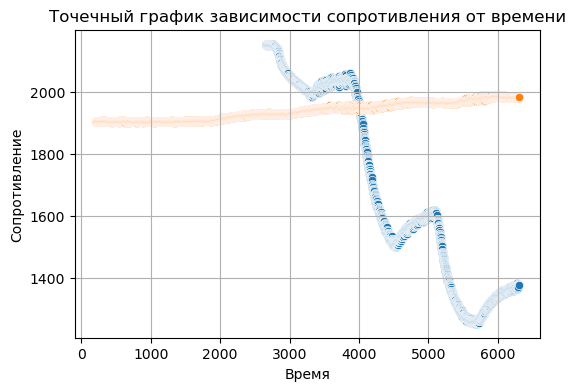

In [116]:
#проверим. что при нормализации ничего толком не поменялось, а также посмотрим на зависимость
def two_graphs(gas1, gas2):
    gas1 = gas1.iloc[1:]
    gas2 = gas2.iloc[1:]

    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas1)# что и откуда берем
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas2)

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    plt.title('Точечный график зависимости сопротивления от времени')
    plt.grid(True)#добавим сеточку

    return plt.show()
dependency_graph = two_graphs(no2_25rh_25t, nh3_2rh_25t)#первый график - синий, второй - оранжевый

In [117]:
#целевая переменная
def target(df,value):
    df['y'] = value
    return df

#NH3 temp = 25
nh3_2rh_25t = target(nh3_2rh_25t,1)
nh3_25rh_25t = target(nh3_25rh_25t,1)
nh3_50rh_25t = target(nh3_50rh_25t,1)
nh3_75rh_25t = target(nh3_75rh_25t,1)
nh3_2rh_25t_another_ppm = target(nh3_2rh_25t_another_ppm,1)

#NO2 temp = 25
no2_2rh_25t = target(no2_2rh_25t,0)
no2_25rh_25t = target(no2_25rh_25t,0)
no2_50rh_25t = target(no2_50rh_25t,0)
no2_75rh_25t = target(no2_75rh_25t,0)

#NO2 temp = 50
no2_2rh_50t = target(no2_2rh_50t,0)

#NO2 temp = 70
no2_2rh_70t = target(no2_2rh_70t,0)

#NO2 temp = 90
no2_2rh_90t = target(no2_2rh_90t,0)
#вывод
no2_2rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_12160\1088662633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = value


,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time,y
1,395.316315,1.0,25,2,-0.999738,-0.022901,0
2,395.515015,1.5,25,2,-0.303459,-0.952844,0
3,395.395874,2.0,25,2,0.973264,0.229688,0
4,395.259003,2.5,25,2,-0.995365,-0.096165,0
5,394.970032,3.0,25,2,-0.676877,-0.736096,0
...,...,...,...,...,...,...,...
12594,205.186600,6300.0,25,2,-0.580102,0.814544,0
12595,205.107727,6300.5,25,2,0.561022,0.827801,0
12596,205.248077,6301.0,25,2,-0.958055,0.286585,0
12597,205.188324,6301.5,25,2,-0.575255,-0.817974,0


In [118]:
##############ДЛЯ ТРЭЙН ТЕСТА###########################
########ВНИМАНИЕ#####
#данные для обучения состоят только из конкатенации этих двух файлов
common_data = pd.concat([nh3_2rh_25t,
                         nh3_25rh_25t,
                         nh3_50rh_25t,
                         nh3_75rh_25t, 
                         nh3_2rh_25t_another_ppm, 
                         no2_2rh_25t, 
                         no2_25rh_25t,
                         no2_50rh_25t, 
                         no2_75rh_25t, 
                         no2_2rh_50t, 
                         no2_2rh_70t,
                         no2_2rh_90t,], ignore_index=True)

# Отделим целевую переменную в список
target_data = common_data['y'].tolist()

#теперь избавимся от столбца y
common_data_no_y = common_data.drop('y', axis = 1)

#Преобразуем теперь наши данные в список(для обучения надо так)
def dataframe_to_list_of_lists(df):
    """Преобразует датафрейм в список списков, где каждый внутренний список представляет строку датафрейма"""
    list_of_lists = []
    for _, row in df.iterrows():
        list_of_lists.append(row.tolist())
    return list_of_lists

X_data = dataframe_to_list_of_lists(common_data_no_y)
X_data

[[1901.853515625,
  209.0,
  25.0,
  25.0,
  -0.9990098471584218,
  -0.04448960868008041],
 [1904.6884765625, 209.5, 25.0, 25.0, -0.5942451000787458, 0.8042840052073654],
 [1901.671875, 210.0, 25.0, 25.0, 0.6601896897082162, -0.7510989106655456],
 [1903.111328125, 210.5, 25.0, 25.0, 0.9961843711986683, 0.08727369924274872],
 [1903.24609375, 211.0, 25.0, 25.0, -0.9079047553196034, -0.4191765204159831],
 [1902.96875, 211.5, 25.0, 25.0, 0.5440203984022746, -0.8390719910247454],
 [1902.3118896484375,
  212.0,
  25.0,
  25.0,
  0.9998711157572797,
  -0.016054652730363418],
 [1904.6085205078125,
  212.5,
  25.0,
  25.0,
  -0.16785309576644428,
  -0.9858120197287213],
 [1904.085205078125,
  213.0,
  25.0,
  25.0,
  -0.12716515947939225,
  0.9918815565452261],
 [1903.2457275390625,
  213.5,
  25.0,
  25.0,
  -0.8914312925063028,
  -0.453155879075338],
 [1903.2298583984375,
  214.0,
  25.0,
  25.0,
  -0.9648755533464777,
  -0.26270737818783957],
 [1902.8182373046875,
  214.5,
  25.0,
  25.0,
  

In [119]:
# Разделение на тренировочную и валидационную выборки
# в целом здесь можно конечно посмотреть и еще некоторые атрибуты, чтобы разделит удобно, но в целом
#итак неплохо 
X_train, X_val, y_train, y_val = train_test_split(X_data, target_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(f"Размер тренировочной выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")
class_0_count = 0
class_1_count = 0

for element in y_test:
    if element == 0:
        class_0_count += 1
    elif element == 1:
        class_1_count += 1

print(f"Количество элементов класса 0(диоксид азота): {class_0_count}")
print(f"Количество элементов класса 1(аммиак): {class_1_count}")


Размер тренировочной выборки: 87815
Размер валидационной выборки: 10977
Размер тестовой выборки: 10977
Количество элементов класса 0(диоксид азота): 6486
Количество элементов класса 1(аммиак): 4491


In [120]:
# Преобразование данных в тензоры PyTorch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)# из нумпая в тензор, данные как float32 
y_train_tensor = torch.tensor(y_train, dtype=torch.long) #long -  для классификации(указывает типа, что это прям переменные класса именно, а не просто признаки)


x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Модель RNN
class SimpleRNN(nn.Module):#базовый модуль для всех нейронок библиотеки
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()# конструктор из класса-родителя, для инициализации
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)#dim батча - первая размерность входного тензора
        self.fc = nn.Linear(hidden_size, output_size)#полностью связанный слой, используется для преобразования скрытого состояния в выходной вектор
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #Создаем тензор нулей, начальное скрытое состояние (h0)
        #1: dim, соответствующая направлению RNN (в данном случае - 1, так как RNN не двунаправленный)
        #x.size(0): Размер батча (количество примеров в батче)
        #self.hidden_size: Размер скрытого состояния
        h0 = torch.zeros(1, x.size(0), self.hidden_size)# Инициализация hidden state, важное изменение для batch_first=True
        out, hn = self.rnn(x, h0) #hn - последнее скрытое состояние, out - выход rnn содержит скрытое состояние на каждом временном шаге
        out = self.fc(out[:, -1, :]) #все элементы батча, посл вр шаг, все знач скрыт. сост.
        out = self.sigmoid(out)
        return out

# Гиперпараметры
input_size = 6# количество элементов в каждом подмассиве нашего массива
hidden_size = 16# подбираем сами, такое количество вполне норм сейчас
output_size = 1# выходной слой
learning_rate = 0.01# размер шага для нашего алгоритма оптимизации
epochs = 300
batch_size = len(X_train)#соответствует длине данных, В ОБЩЕМ СЛУЧАЕ ЛУЧШЕ ЧУТЬ ПОДПРАВИТЬ ЭТО


model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
for epoch in range(epochs):
    optimizer.zero_grad()#сбрасываем градиенты оптимизатора до нуля, иначе с расчетом весов будет проблема
    outputs = model(x_train_tensor.unsqueeze(1)) # Добавляем дополнительную размерность для времени
    loss = criterion(outputs.squeeze(1), y_train_tensor.float()) # Снимаем лишнее измерение
    loss.backward()
    optimizer.step()#обновляем веса модели
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            train_predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
            train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.squeeze(1).numpy())

            # Оценка на валидационных данных
            val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
            val_loss = criterion(val_predictions.squeeze(1), y_val_tensor.float())
            val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.squeeze(1).numpy())

            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


#Оценка точности после обучения
with torch.no_grad():
    predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
    accuracy = accuracy_score(y_train_tensor.numpy(), predictions.squeeze(1).numpy())
    print(f'\nTrain Accuracy: {accuracy:.4f}')

with torch.no_grad():
    final_val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
    final_val_accuracy = accuracy_score(y_val_tensor.numpy(), final_val_predictions.squeeze(1).numpy())
    print(f'\nValidation Accuracy: {final_val_accuracy:.4f}')


Epoch [10/300], Loss: 0.6365, Accuracy: 0.6747, Val Loss: 33.3060, Val Accuracy: 0.6669
Epoch [20/300], Loss: 0.6180, Accuracy: 0.6724, Val Loss: 33.5793, Val Accuracy: 0.6642
Epoch [30/300], Loss: 0.6106, Accuracy: 0.6775, Val Loss: 33.0418, Val Accuracy: 0.6696
Epoch [40/300], Loss: 0.6016, Accuracy: 0.6800, Val Loss: 32.8141, Val Accuracy: 0.6719
Epoch [50/300], Loss: 0.5894, Accuracy: 0.6795, Val Loss: 32.8961, Val Accuracy: 0.6710
Epoch [60/300], Loss: 0.5748, Accuracy: 0.6854, Val Loss: 32.2584, Val Accuracy: 0.6774
Epoch [70/300], Loss: 0.5392, Accuracy: 0.6799, Val Loss: 32.7503, Val Accuracy: 0.6725
Epoch [80/300], Loss: 0.4613, Accuracy: 0.8590, Val Loss: 14.3117, Val Accuracy: 0.8569
Epoch [90/300], Loss: 0.4088, Accuracy: 0.8667, Val Loss: 13.5101, Val Accuracy: 0.8649
Epoch [100/300], Loss: 0.3921, Accuracy: 0.8784, Val Loss: 12.3349, Val Accuracy: 0.8767
Epoch [110/300], Loss: 0.3468, Accuracy: 0.8742, Val Loss: 12.4989, Val Accuracy: 0.8750
Epoch [120/300], Loss: 0.3359,

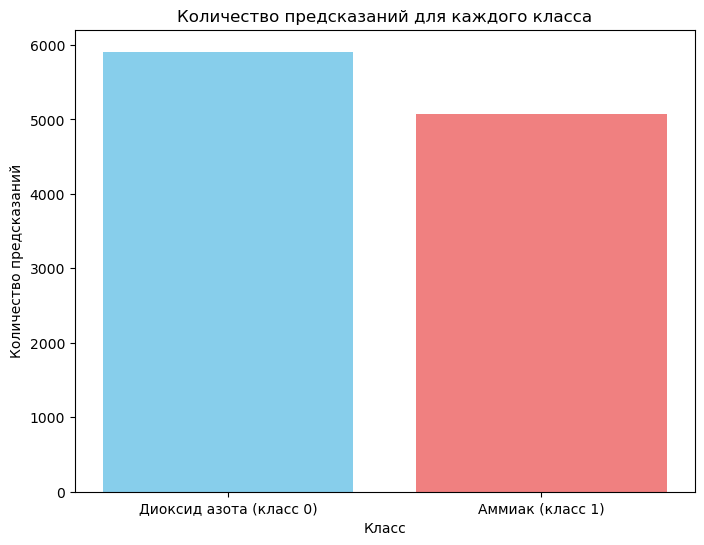

Вероятность принадлежности к классу аммиака: 0.9468974471092224 - это аммиак
Вероятность принадлежности к классу аммиака: 0.6474583745002747 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9936081217601895 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9936081217601895 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.9468974471092224 - это аммиак
Вероятность принадлежности к классу аммиака: 0.6474583745002747 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.8271803110837936 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9936081217601895 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.9034239053726196 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.8841365948319435 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.6474583745002747 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9936081217601895 - это диокси

In [121]:
# Преобразование тестовых данных
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Оценка на тестовой выборке
with torch.no_grad():
    test_outputs = model(x_test_tensor.unsqueeze(1))
    test_predictions = (test_outputs > 0.5).float()
    #test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.squeeze(1).numpy())

#print(f'Test Accuracy: {test_accuracy:.4f}')
# Подсчет количества предсказаний для каждого класса
class_counts = test_predictions.squeeze(1).numpy()
unique, counts = np.unique(class_counts, return_counts=True)
class_counts_dict = dict(zip(unique, counts))

# Построение графика
labels = ['Диоксид азота (класс 0)', 'Аммиак (класс 1)']
counts = [class_counts_dict.get(0.0,0), class_counts_dict.get(1.0,0)] #Обработка случая, если какого-то класса нет в предсказаниях

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Количество предсказаний для каждого класса')
plt.ylabel('Количество предсказаний')
plt.xlabel('Класс')
plt.show()

nh3 = 0
no2 = 0
# Логика для вывода класса
for i, prob in enumerate(test_outputs.squeeze(1)):
    if prob.item() > 0.5:
        nh3+=1
        print(f"Вероятность принадлежности к классу аммиака: {prob.item()} - это аммиак")
    else:
        no2+=1
        print(f"Вероятность принадлежности к классу диоксида азота: {1-prob.item()} - это диоксид азота")
print(f"Количество предсказаний за аммиак: {nh3}")
print(f"Количество предсказаний за диоксид азота: {no2}")